# Automatic data analysis and plotting.
Update: 14 $^{th}$ August 2025

__Notes:__  
Tested for the following dgbowl library version:
- yadg: 6.1.3
- dgpost: 2.3  

- The issues with software dependencies in the previous version has been partially fixed. Now, one can pip install yadg, dgpost directly without software conflict. The order of installation matters, yadg must be installed first, fellow by dgpost.

- yadg 6.1.3 includes a fix that handle file codec error. We still don't know what caused this issue, but sometime the potentiostat recorded data that cannot be decoded using utf-8 standard. This crashed yadg step in the past. Normally we either have to convert the file into .mpt or re-run the experiment completly. This new version address this issue. 

### New features in this version
- __Show log__: In aa.auto_dgbowl, if show_log=True (in single CPU mode), then all log from terminal will be displayed directly in this Jupyter Notebook. This will allow ease of debugging in case there is a bug with a particular experiment folder. 

- __clean_temp_dir__: In aa.auto_dgbowl, if clean_temp_dir=Flase, the sliced folder in recipe/data_for_dgbowl which is the actual data folder being submitted to yadg will be preserved. Normally this folder is deleted to avoid cluttering. This option will make debugging to be easier as the recipe files are preserved in that folder. 

- __Abort dgpost if yadg steps failed__: In this latest version, Autoplot will abort dgpost step if yadg step fails. This will save analysis time and make debudding easier.

### __How to use__
- Put the files to be analyzed in the Data folder.
- Click Run All button. 
- The processed files will be put in the Output folder. 
- The exported graph will be placed in Graph_Export folder. 


### __Supported experiment type__
 - __Single experiment__
    - With/ without LC data.
    - With / without temperature data
    - With / without pressure data
    - Flow data (with automatic removing of GC injection data points, this help reducing overshooting of FE due to inconsistent flow.)
        - Recorded with DryCal software. 
        - Recorded with the custom Python script.
        
- __Multiplexing from 2 units and more__
    - With / without temperature data
    - With / without pressure data
    - LC data is supported at this version (provided the LC file is placed directly inside eash unit's folder)
    - Automatic flow data slicing and removing GC valve switching and GC injection data points. The flow data has to be recorded using the custom python script. 
    - Compatible with 1 and more GC folders / flow meter files for one multiplex experiment.

### __Files requirement__
- Please refers to an example files for a better idea on how the file naming should be. 
- **** The naming of the files have to be strictly follow the following convention to ensure the smooth running of the script.
- Unless specified otherwise, no space can be used. Please use underscore (_).
- Unless specified otherwise (LC data has different format), the date info has to be in the format of yyyymmdd. For example: 20230622.

- __Single experiment__

    - __Pressure data (optional):__ Two files are required.
        - pressure file: 
            - In the format of yyyymmdd_XXX-pressure.csv 
            - Inside the file, ensure the columns name are UXLiquid(Read)[mbar] and UXGas(Read)[mbar] (X is the number of the unit)
        - pressure log:
            - In the format of yyyymmdd_XXX-pressurelog.txt
    - __Temperature data (optional):__ One file is required.
        - temperature file:
            - In the format of yyyymmdd_XXX-temperature.csv 
            - The script will take column B as the cell temperature and column D as a room temperature. 
    - __Flow data (required):__ Two files are required. 
        - Flow file: 
            - In the format of yyyymmdd_XXX-flow.csv 
            - This can be from the custom script or from DryCal program. 
        - GC files folder:
            - In the format of yyyymmdd_XXX-GC.zip
            - This is used to remove the artifact points resulted from GC injection. We found that this usually lead to incorrect FE calculation. By default, the script will remove all flow data recorded within the time windows of 75 seconds before and after the GC injection.

- __Multiplex experiment__
    - Capable of analyzing  multiplex experiment from 2 cells onward.
    - For a folder containing a multiplex experiment, the name of the folder must be started with 'Multiplex'
    - The script will take anything between the first and second (if any) underscore as the experiment name: eg. Multiplex2_30p-flow-NoEDC, the exp name will be 30p-flow-NoEDC. Multiplex_20230805_30p-flow-NoEDC, exp name will be 20230805.

    -__Flow data (required):__
        - Must be in the format of collection-[sequence of unit]-flow.csv. For example, if the the said flow data stores the flow data from unit U2 and U4 (alternating) the naming would be collection-U2-U4-flow.csv. 

    -__GC data (required):__
        - Must be in the format of collection-[sequence of unit]-GC.zip. For example, if the the said flow data stores the flow data from unit U2 and U4 (alternating) the naming would be collection-U2-U4-GC.zip 
    
    -__Echem files (required):__ 
        - Echem files for each unit must be stored inside a unit folder (naming UX, where X is the unit number.)

    -__Pressure data (optional):__ 
        - pressure file: 
            - In the format of yyyymmdd_XXX-pressure.csv 
            - Inside the file, ensure the columns name are UXLiquid(Read)[mbar] and UXGas(Read)[mbar] (X is the number of the unit). The script will slice take the pressure from the number in this file. Make sure there are columns from U1 to U8. 
        - pressure log:
            - In the format of yyyymmdd_XXX-pressurelog.txt

    -__Temperature data (optional):__ One file is required.
        - temperature file:
            - In the format of yyyymmdd_XXX-temperature.csv 
            - The temp column of each unit is in the format of Unit X Last (C). Note that here the space is used. The room temperature is in the column called RT-external Last (C). 

In [1]:
#Other modules
import warnings
import importlib # incase we need to reload a module (for testing)

#Modules for AutoDB
from Recipe.workflow import libcheck
libcheck.ensure_dependencies()
from Recipe.workflow import autoanalyze as aa
from Recipe.workflow import autoplot as ap
from Recipe.workflow import auxiliary as aux
from Recipe.workflow.dynamic_recipe import recifier, templates



'yadg' is already installed.
'dgpost' is already installed.


## File removal from the data folder
- Since renku does not allow one to remove the folder directly if there is any files inside. This has to be done programmatically. So, use the following command (uncomment them) to remove the file in Data and in Output folder. USE with cautious!!

In [ ]:
#aux.clear_dir('Output')
#aux.clear_dir('Data')

##  Extracting zip file
- The data files will needed to be zip first and dropped into the Data folder. Then run the command in the following script to unzip the files.

In [2]:
aux.unzip_and_organize()

Unzipping ./Data/20220608-porosity-study-15p-Cu-25mA.zip into temporary directory...
Successfully extracted ./Data/20220608-porosity-study-15p-Cu-25mA.zip into ./Data


## Data slicing
- Clean 'Recipe/data_for_dgbowl' for any old data and prepare for the current data.
- Slice data and prepare them for processing. 

In [3]:
importlib.reload(aux)

aux.clear_dir('Recipe/data_for_dgbowl')
aux.clear_dir('Output') #!! Warning this is for development purposes only. Do not call this function when analyzing the data

aux.data_slicer()

Data slicing or preparation for yadg,dgpost status: 

------------------------------------------------------------------
Folder:  20220608-porosity-study-15p-Cu-25mA
Successfully sliced: Flow
Failed to slice: Temperature, Pressure
20220608-porosity-study-15p-Cu-25mA will be subjected to yadg/dgpost

------------------------------------------------------------------
------------------------------------------------------------------
Folder:  __MACOSX
Successfully sliced: 
Failed to slice: Flow, Temperature, Pressure
!! WARNING: __MACOSX will NOT be subjected to yadg/dgpost

------------------------------------------------------------------


## yadg and dgpost
- ### Multiprocessing
    - __False:__
        - The script will process the data folder by folder using only one CPU core. This method can be slower in many cases but will ensure that the sure can use a computer while running the script. 
    - __True:__
        - The script will use ALL of the CPU cores avilable in the machine to process the data. Each core will responsible for one folder. 
        - This can greatly reduce the time required for processing the data, and the processing time will be greatly be affected by the computational power of the machine. 
        - WARNING!! Using this feature can make the machine become lag to the point where other task cannot be run and cause programs to crash. It is highly adviced to leave the machine running the script and not working on other programs. In case of large files (especially for multiplex8 experiment), the system can run out of memory (RAM), resulting in a slow down of the system. In such case, single core processing is adviced (Multiprocessing=False). 

- ### Mannual recipe
    - This feature allows the user to choose whether they will manually create the recipe for yadg and dgpost themselves or will let the system to dynamically create the recipes based on the data avilability and the experiment being run. 
    - __manual_recipe=True__: The user will create a custom recipe for yadg/dgpost and put the recipes in Recipe/yadg and Recipe/dgpost
    - __manual_recipe=False__: The user will let the system to dynamically generate the recipe for yadg / dgpost.
        - Currently,only the dgpost recipe will be adjusted. Here are the following points that the script will look into and adjust the recipe accordingly:
            - __Temperature__:
                - If there is a temperature file, the recipe will read the temp. data
                - If there is no temperature file, the recipe will put the default of 20 Celcius. 
            - __Pressure__:
                - The recipe will extract the pressure file only if there is a pressure files. 
            - __pH__:
                - The recipe will extract the pH from the metadata file.
            - __LC data__:
                - The script will generate the recipe for LC files, only if there is LC data. 
            - __Correctly assgined the charge to C for each experiment__:
                - The charge for C wil be assigned to 4 for CO<sub>2</sub>RR and 2 for CORR for the caluclation of FE for GC. 
                - The information on the reaction being performed will be extracted from the metadata file. 

In [4]:
importlib.reload(aa)
importlib.reload(recifier)
importlib.reload(templates)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") #Suppress UserWarning from openpyxl library
aa.auto_dgbowl(multi_processing=False, show_log=True, manual_recipe=False, clean_temp_dir=True)




************************************************************** 

Start processing yadg/dgpost (Using single CPU core) 

**************************************************************




************************************************************ 

Start yadg on: 20220608-porosity-study-15p-Cu-25mA 

************************************************************


/opt/miniconda3/envs/autoplot/lib/python3.13/site-packages/yadg/dgutils/dsutils.py:82: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  vals[k] = xr.concat([vals[k], fvals[k]], dim="uts", combine_attrs=mode)


************************************************************** 

Start dgpost on:

## Automatic graph plotting
__Avilable variable to control the appearance of graph__
| Parameter         | Explanation                                 | Default Value |
|-------------------|---------------------------------------------|---------------|
| `y_label_shift`   | Controlling the shift of the ylabel.        | -0.085        |
| `ytick_label_size`| Controlling font size of numbers on y-axis  | 11            |
| `xtick_label_size`| Controlling font size of numbers on x-axis  | 11            |
| `yaxis_label_size`| Controlling font size of y-axis label.      | 11            |

- To use these, simply add this to dir_make_graph function.


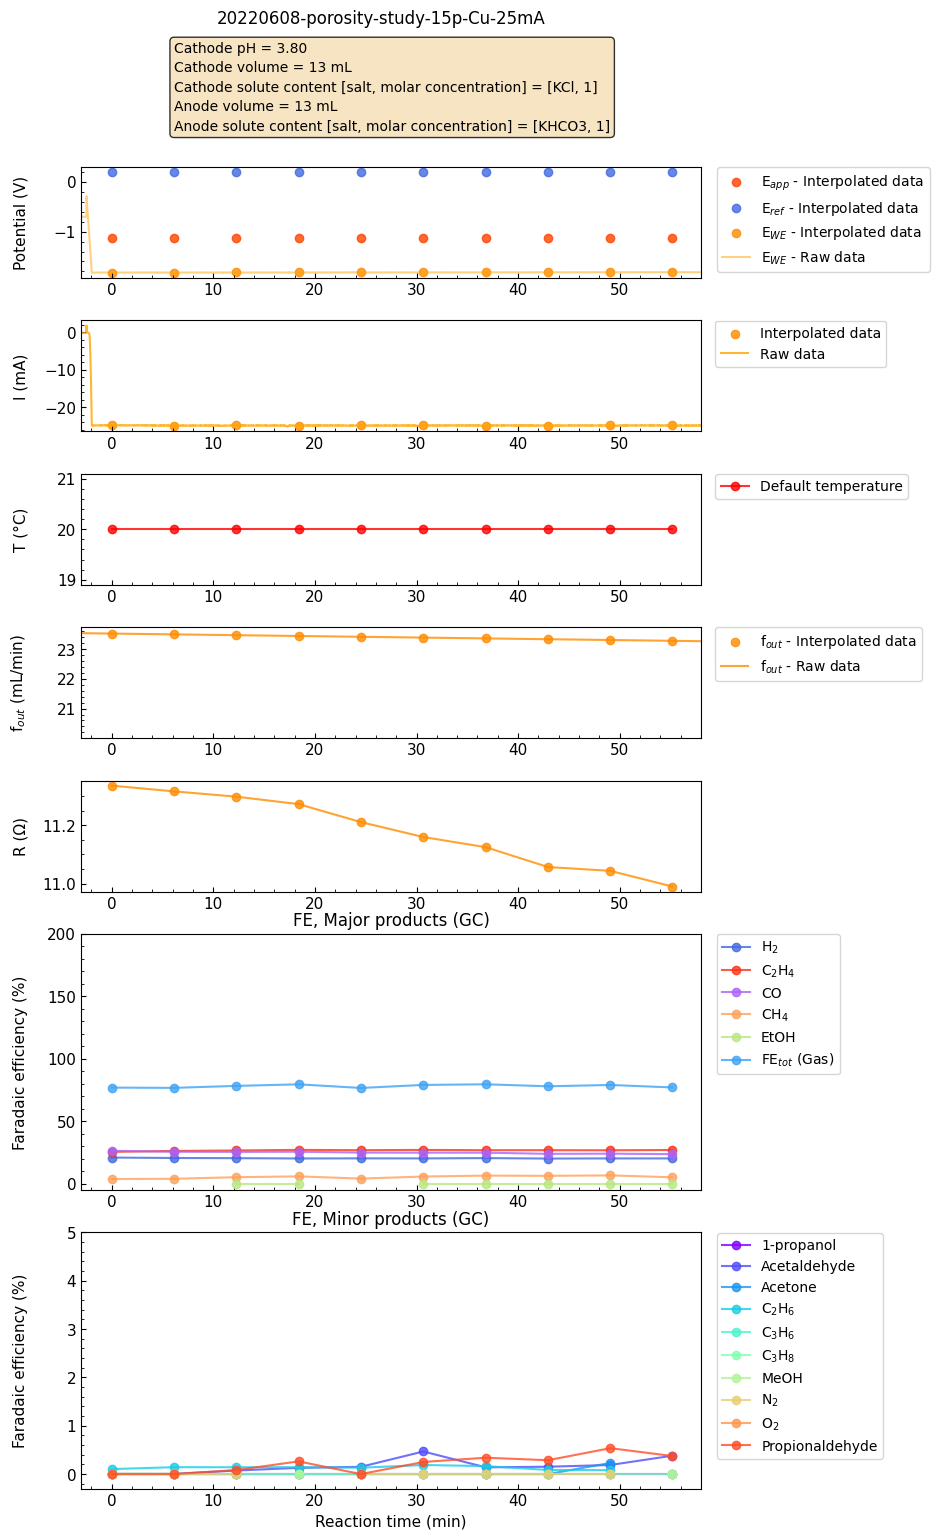

No files containing 'LCdata.xlsx' were found in the given path.


In [5]:
importlib.reload(ap) # Incase I want to re-load the module during testing.
importlib.reload(recifier)
importlib.reload(templates)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") #Suppress UserWarning from openpyxl library


ap.dir_make_graph(type='GC', format='png', save_fig=False, path_output='Graph_Export')
ap.dir_make_graph('Output',type='LC', save_fig=False, path_output='Graph_Export')

###  Zip all the output for download
- This fnction is quired as Renku do not allow download of the entire folder. Instead, running the following command wil zip all of the folder into 1 folder, you can then subsequently download this zip file.

- After the output.zip was made, simply roght click and download it.

In [6]:
aux.zip_folder()

Zipping complete. Archive saved as ./Output/output.zip.
